In [122]:
import os
import os.path 
import pandas as pd
import re
import numpy as np
import math
import cv2 as cv
from matplotlib import pyplot as plt
import imutils as im


In [123]:
def ImportImage(folder):
    images = []
    filenames = []
    datalabel = []
    for label in os.listdir(folder):
        
        for filename in os.listdir(folder+label):
            img = cv.imread(os.path.join(folder+label, filename))
            rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            # hsv = cv.cvtColor(rgb, cv.COLOR_RGB2HSV)
            filenames.append(filename)
            datalabel.append(label)
            if img is not None:
                images.append(rgb)
    return images, filenames, datalabel

images, filenames, label = ImportImage("Data Set/")

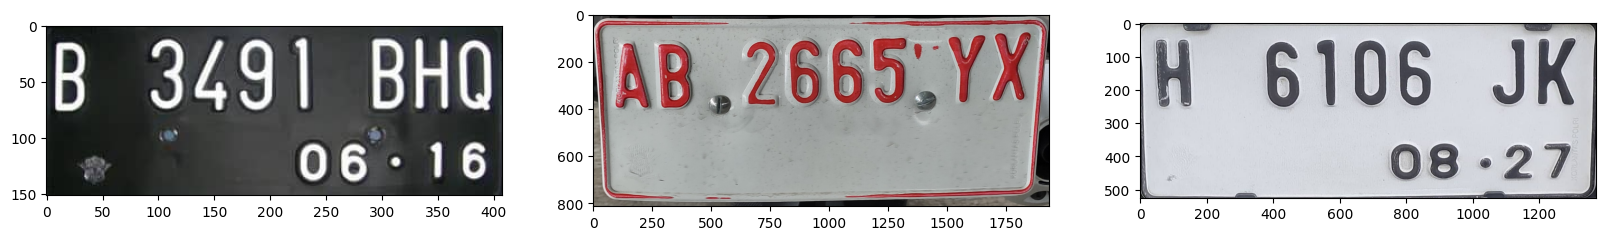

In [124]:
def tampilFoto(img):
    plt.figure(figsize=(20,20))
    for i in range(len(img)):
        plt.subplot(1,len(img),i+1)
        plt.imshow(img[i], cmap='gray')
tampilFoto([images[0], images[200], images[299]])

In [125]:
def segmentationRed(image):
    hsv = cv.cvtColor(image, cv.COLOR_RGB2HSV)
    mask = cv.inRange(hsv, (136, 87, 111), (180, 255, 255))
    # imask = mask>0
    # result = np.zeros_like(img, np.uint8)
    # result[imask] = img[imask]
    result = cv.bitwise_and(image, image, mask=mask)

    return result

# def segmentationGreen(image):
#     hsv = cv.cvtColor(image, cv.COLOR_RGB2HSV)
#     mask = cv.inRange(hsv, (25, 52, 72), (102, 255, 255))
#     # imask = mask>0
#     # result = np.zeros_like(img, np.uint8)
#     # result[imask] = img[imask]
#     result = cv.bitwise_and(image, image, mask=mask)

#     return result

# def segmentationYellow(image):
#     hsv = cv.cvtColor(image, cv.COLOR_RGB2HSV)
#     mask = cv.inRange(hsv, (94, 80, 2), (120, 255, 255))
#     # imask = mask>0
#     # result = np.zeros_like(img, np.uint8)
#     # result[imask] = img[imask]
#     result = cv.bitwise_and(image, image, mask=mask)

#     return 
def segmentationWhite(image):
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    lower_white = np.array([0, 0, 200], dtype=np.uint8)
    upper_white = np.array([180, 25, 255], dtype=np.uint8)
    mask = cv.inRange(hsv, lower_white, upper_white)
    result = cv.bitwise_and(image, image, mask=mask)
    
    return result
def segmentationBlack(image):
    gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    _, threshold = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV)
    result = cv.bitwise_and(image, image, mask=threshold)

    return result
def segmentation(image):
    return segmentationWhite(image)+segmentationRed(image)+segmentationBlack(image)
def rgb(image):
    image = image.transpose()
    rs = image[0]
    gs = image[1]
    bs = image[2]

    rmean = np.mean(rs)
    gmean = np.mean(gs)
    bmean = np.mean(bs)

    rmax= np.amax(rs)
    gmax= np.amax(gs)
    bmax= np.amax(bs)

    return [rmean, gmean, bmean, rmax, gmax, bmax]

In [126]:
resizes = []
for image in images:
    result = im.resize(image, height=200, width=512,inter=cv.INTER_AREA)
    resizes.append(result)

In [127]:
normalize = []
for image in resizes:
    image = cv.normalize(image, None, alpha=0,beta=200, norm_type=cv.NORM_MINMAX) 
    normalize.append(image)

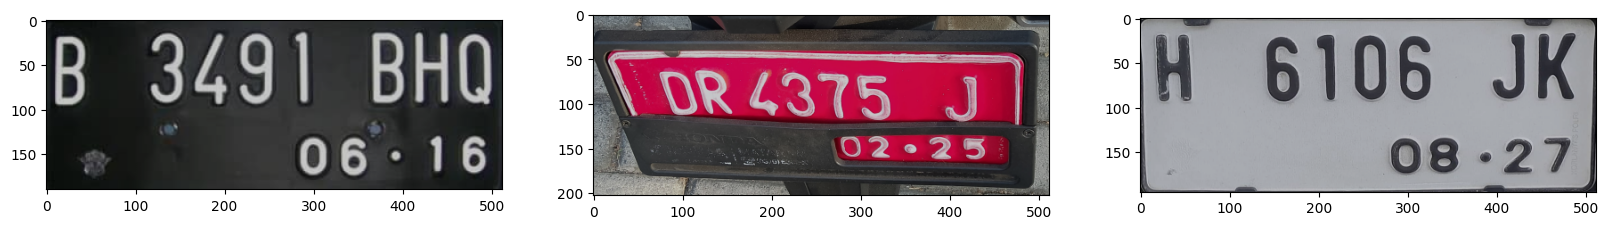

In [128]:
tampilFoto([normalize[0],normalize[160],normalize[299]])

In [129]:
def median_filter(image):
    filtered_image = cv.medianBlur(image, 5)
    return filtered_image

In [130]:
medians = []
# for median in normalize:
#     median = median_filter(median)
#     medians.append(median)
for i in range(len(normalize)):
    median = median_filter(normalize[i])
    medians.append(median)

In [131]:
segments=[]
for image in images:
    segments.append(segmentation(image))

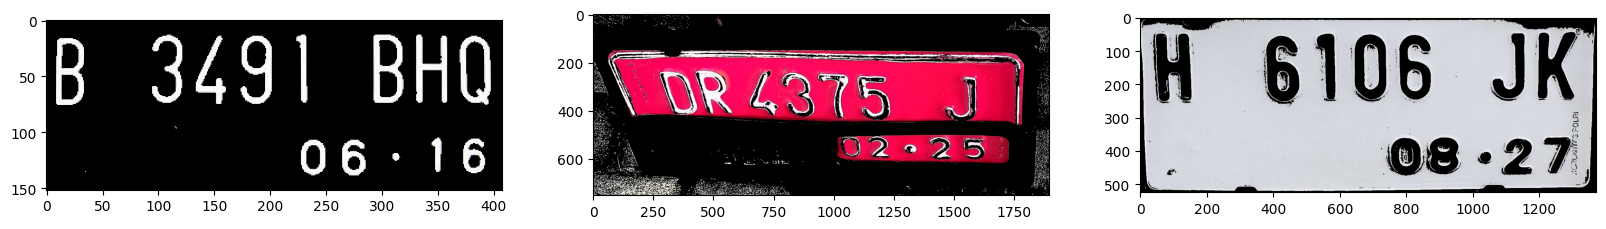

In [132]:
tampilFoto([segments[0],segments[160],segments[299]])

In [133]:
def eros(image):
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    
    gradient_x = cv.Sobel(gray, cv.CV_64F, 1, 0, ksize=3)
    gradient_y = cv.Sobel(gray, cv.CV_64F, 0, 1, ksize=3)
    
    result = np.sqrt(gradient_x**2 + gradient_y**2)
    
    return result

In [134]:
eroded = []
for erosi in segments:
    erosi = eros(erosi)
    eroded.append(erosi)

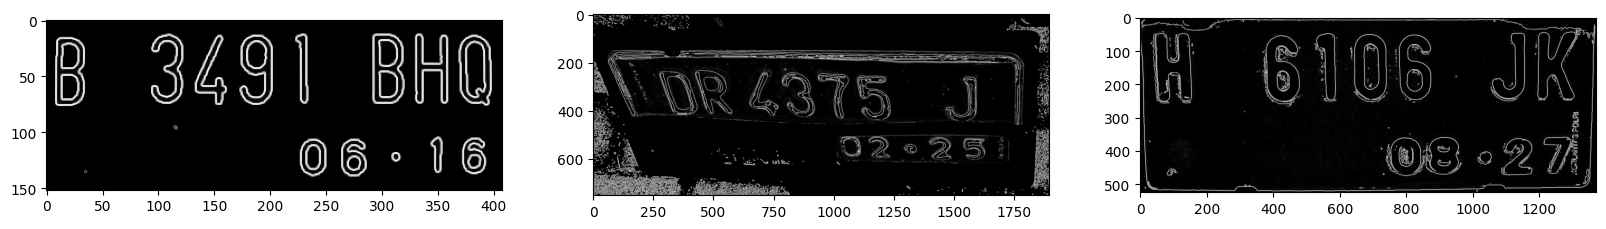

In [136]:
tampilFoto([eroded[0],eroded[160],eroded[299]])

In [137]:
masked = []
for index, mask in enumerate(eroded):
    img = normalize[index]

    mask = mask.astype(np.uint8)
    mask = cv.resize(mask, (img.shape[1], img.shape[0]))  # Perbarui ukuran mask jika perlu

    masked_img = cv.bitwise_and(img, img, mask=mask)
    masked.append(masked_img)

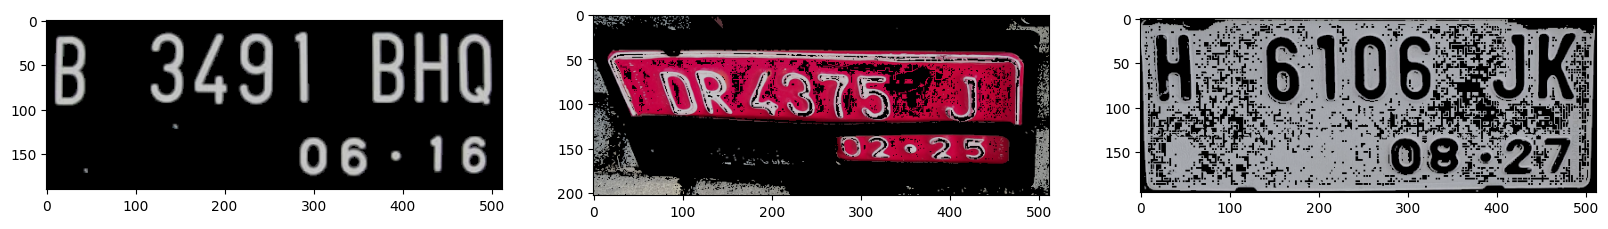

In [138]:
tampilFoto([masked[0],masked[160],masked[299]])

In [139]:
features = []
for image in segments:
    feature = rgb(image)
    features.append(feature)

In [140]:
filenames = pd.DataFrame(filenames, columns=["filenames"])
labelsdf = pd.DataFrame(label, columns=["labels"])

In [141]:
def export(data, namafile, column):
    glcm_df = pd.DataFrame(data, columns = column)
    glcm_df.to_csv(namafile)

In [142]:
fitur = pd.DataFrame(features, columns=["hmean", "smean", "vmean", "hmax", "smax", "vmax"])
fitur.head()
columns=["hmean", "smean", "vmean", "hmax", "smax", "vmax"]
export(fitur, 'fitur.csv', columns)

In [143]:
def exportCiri(filenames, fitur, label):
    glcm_df = pd.concat([filenames, fitur, label], axis=1)
    glcm_df.to_csv('ciri.csv')

In [145]:
ciri = pd.concat([filenames, fitur, labelsdf], axis=1)
ciri.head()
exportCiri(filenames, fitur, labelsdf)

In [146]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [148]:
x = fitur.values
y = labelsdf.values.ravel()
x_train, x_test, y_train, y_test = train_test_split(x, y , test_size=0.2, random_state=21)

In [149]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [150]:
modelnb = KNeighborsClassifier(n_neighbors=5)

nbtrain = modelnb.fit(x_train, y_train)
y_pred = nbtrain.predict(x_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

       Hitam       0.70      1.00      0.82        16
       Merah       0.95      0.95      0.95        20
       Putih       1.00      0.71      0.83        24

    accuracy                           0.87        60
   macro avg       0.88      0.89      0.87        60
weighted avg       0.90      0.87      0.87        60

0.8666666666666667
